In [1]:
# =====================================================
# 0) IMPORTS
# =====================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

In [2]:
# =====================================================
# 1) LOAD & INSPECT DATA
# =====================================================

# Simple loading from local CSV
df = pd.read_csv("European Restaurant Reviews.csv")

print("🔹 First 5 rows:")
print(df.head())

print("\n🔹 Columns:")
print(df.columns)

print("\n🔹 Missing values BEFORE any modification:")
print(df.isnull().sum())

🔹 First 5 rows:
  Country            Restaurant Name Sentiment  \
0  France  The Frog at Bercy Village  Negative   
1  France  The Frog at Bercy Village  Negative   
2  France  The Frog at Bercy Village  Negative   
3  France  The Frog at Bercy Village  Negative   
4  France  The Frog at Bercy Village  Negative   

                                Review Title Review Date  \
0                               Rude manager  May 2024 •   
1                       A big disappointment  Feb 2024 •   
2               Pretty Place with Bland Food  Nov 2023 •   
3   Great service and wine but inedible food  Mar 2023 •   
4  Avoid- Worst meal in Rome - possibly ever  Nov 2022 •   

                                              Review  
0  The manager became agressive when I said the c...  
1  I ordered a beef fillet ask to be done medium,...  
2  This is an attractive venue with welcoming, al...  
3  Sadly I  used the high TripAdvisor rating too ...  
4  From the start this meal was bad- especially

In [3]:
# =====================================================
# 2) ADD & CLEAN NaN (ARTIFICIAL) – OPTIONAL TRAINING STEP
# =====================================================

# Make a copy to simulate dirty data
df_dirty = df.copy()

# Add 2% NaN to Review and Sentiment to practice cleaning
np.random.seed(42)
n_rows = len(df_dirty)
n_missing = int(0.02 * n_rows)

missing_indices_review = np.random.choice(df_dirty.index, size=n_missing, replace=False)
missing_indices_sentiment = np.random.choice(df_dirty.index, size=n_missing, replace=False)

df_dirty.loc[missing_indices_review, "Review"] = np.nan
df_dirty.loc[missing_indices_sentiment, "Sentiment"] = np.nan

print("\n🔹 AFTER adding artificial NaN:")
print(df_dirty.isnull().sum())

print("\n🔹 Number of rows BEFORE cleaning:", len(df_dirty))

# Drop rows with NaN in Review or Sentiment
df_clean = df_dirty.dropna(subset=["Review", "Sentiment"]).copy()

print("🔹 Number of rows AFTER cleaning:", len(df_clean))

print("\n🔹 Missing values AFTER cleaning:")
print(df_clean.isnull().sum())


🔹 AFTER adding artificial NaN:
Country             0
Restaurant Name     0
Sentiment          30
Review Title        0
Review Date         0
Review             30
dtype: int64

🔹 Number of rows BEFORE cleaning: 1502
🔹 Number of rows AFTER cleaning: 1443

🔹 Missing values AFTER cleaning:
Country            0
Restaurant Name    0
Sentiment          0
Review Title       0
Review Date        0
Review             0
dtype: int64



🔹 Class counts (Sentiment):
Sentiment
Positive    1190
Negative     253
Name: count, dtype: int64

🔹 Class percentage (Sentiment):
Sentiment
Positive    82.467082
Negative    17.532918
Name: proportion, dtype: float64

🔹 Class distribution table:
           count    percent
Sentiment                  
Positive    1190  82.467082
Negative     253  17.532918


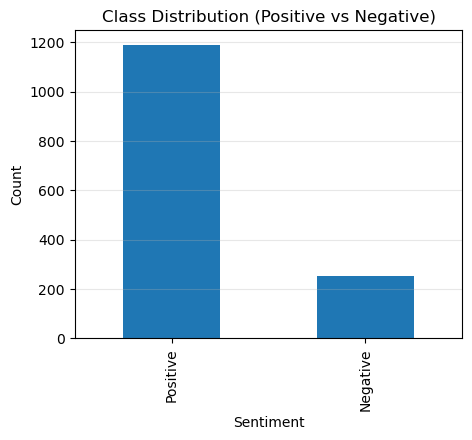

In [4]:
# =====================================================
# 3) CLASS DISTRIBUTION + SIMPLE EDA PLOT
# =====================================================

print("\n🔹 Class counts (Sentiment):")
print(df_clean["Sentiment"].value_counts())

print("\n🔹 Class percentage (Sentiment):")
print(df_clean["Sentiment"].value_counts(normalize=True) * 100)

class_dist = pd.DataFrame({
    "count": df_clean["Sentiment"].value_counts(),
    "percent": df_clean["Sentiment"].value_counts(normalize=True) * 100
})
print("\n🔹 Class distribution table:")
print(class_dist)

# Plot class distribution
plt.figure(figsize=(5, 4))
df_clean["Sentiment"].value_counts().plot(kind="bar")
plt.title("Class Distribution (Positive vs Negative)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()

In [5]:
# =====================================================
# 4) PREPARE X, y AND TRAIN/TEST SPLIT
# =====================================================

# Features (text reviews) and labels (sentiment)
X = df_clean["Review"]
y = df_clean["Sentiment"]

# Stratified split to keep sentiment ratios similar in train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\n🔹 Train size:", len(X_train))
print("🔹 Test size :", len(X_test))

print("\n===== CLASS DISTRIBUTION IN TRAIN =====")
print(y_train.value_counts(normalize=True) * 100)

print("\n===== CLASS DISTRIBUTION IN TEST =====")
print(y_test.value_counts(normalize=True) * 100)


🔹 Train size: 1154
🔹 Test size : 289

===== CLASS DISTRIBUTION IN TRAIN =====
Sentiment
Positive    82.495667
Negative    17.504333
Name: proportion, dtype: float64

===== CLASS DISTRIBUTION IN TEST =====
Sentiment
Positive    82.352941
Negative    17.647059
Name: proportion, dtype: float64



===== BASELINE MODEL (No Class Weight) =====
Accuracy: 0.9100346020761245

Classification Report (Baseline):
              precision    recall  f1-score   support

    Negative       1.00      0.49      0.66        51
    Positive       0.90      1.00      0.95       238

    accuracy                           0.91       289
   macro avg       0.95      0.75      0.80       289
weighted avg       0.92      0.91      0.90       289


Confusion Matrix (Baseline):
[[ 25  26]
 [  0 238]]


<Figure size 400x400 with 0 Axes>

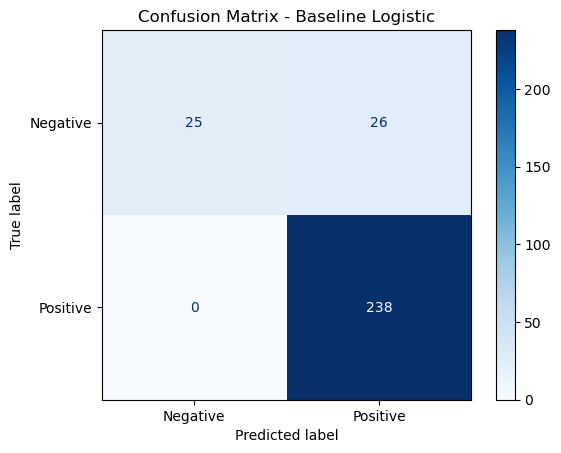

In [6]:
# =====================================================
# 5) TF-IDF + BASELINE LOGISTIC REGRESSION (NO CLASS WEIGHT)
# =====================================================

tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=5000,
    ngram_range=(1, 2)
)

# Transform text into TF-IDF features
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Baseline Logistic Regression (no class_weight)
logit_baseline = LogisticRegression(max_iter=500)
logit_baseline.fit(X_train_tfidf, y_train)

# Predictions
y_pred_base = logit_baseline.predict(X_test_tfidf)

print("\n===== BASELINE MODEL (No Class Weight) =====")
base_acc = accuracy_score(y_test, y_pred_base)
print("Accuracy:", base_acc)

print("\nClassification Report (Baseline):")
print(classification_report(y_test, y_pred_base))
cm_base = confusion_matrix(y_test, y_pred_base)
print("\nConfusion Matrix (Baseline):")
print(cm_base)

plt.figure(figsize=(4, 4))
ConfusionMatrixDisplay(cm_base, display_labels=logit_baseline.classes_).plot(
    cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix - Baseline Logistic")
plt.show()


===== MODEL WITH CLASS WEIGHT (Balanced) =====
Accuracy: 0.9515570934256056

Classification Report (Balanced):
              precision    recall  f1-score   support

    Negative       0.85      0.88      0.87        51
    Positive       0.97      0.97      0.97       238

    accuracy                           0.95       289
   macro avg       0.91      0.92      0.92       289
weighted avg       0.95      0.95      0.95       289


Confusion Matrix (Balanced):
[[ 45   6]
 [  8 230]]


<Figure size 400x400 with 0 Axes>

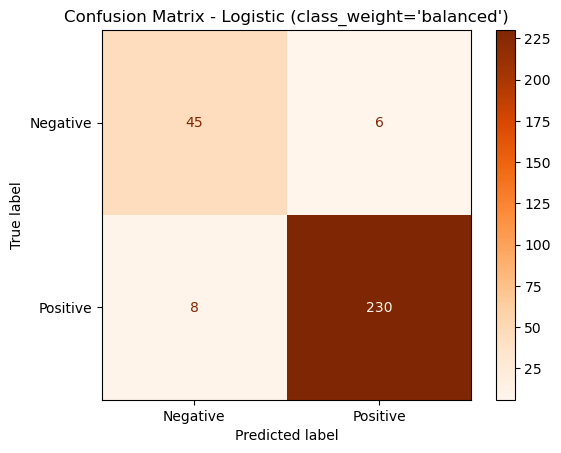

In [7]:
# =====================================================
# 6) LOGISTIC REGRESSION WITH CLASS WEIGHT = 'BALANCED'
# =====================================================

logit_balanced = LogisticRegression(
    max_iter=500,
    class_weight="balanced"
)

logit_balanced.fit(X_train_tfidf, y_train)
y_pred_balanced = logit_balanced.predict(X_test_tfidf)

print("\n===== MODEL WITH CLASS WEIGHT (Balanced) =====")
bal_acc = accuracy_score(y_test, y_pred_balanced)
print("Accuracy:", bal_acc)

print("\nClassification Report (Balanced):")
print(classification_report(y_test, y_pred_balanced))

cm_bal = confusion_matrix(y_test, y_pred_balanced)
print("\nConfusion Matrix (Balanced):")
print(cm_bal)
plt.figure(figsize=(4, 4))
ConfusionMatrixDisplay(cm_bal, display_labels=logit_balanced.classes_).plot(
    cmap="Oranges", values_format="d"
)
plt.title("Confusion Matrix - Logistic (class_weight='balanced')")
plt.show()

Fitting 5 folds for each of 18 candidates, totalling 90 fits

===== BEST PARAMS FROM GRIDSEARCH =====
{'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__solver': 'liblinear', 'tfidf__max_features': 8000, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}
Best CV Score (F1-macro): 0.9334076601573014

===== TEST PERFORMANCE (BEST LOGISTIC MODEL) =====
Accuracy: 0.9757785467128027

Classification Report (Best Logistic):
              precision    recall  f1-score   support

    Negative       0.98      0.88      0.93        51
    Positive       0.98      1.00      0.99       238

    accuracy                           0.98       289
   macro avg       0.98      0.94      0.96       289
weighted avg       0.98      0.98      0.98       289


Confusion Matrix (Best Logistic):
[[ 45   6]
 [  1 237]]


<Figure size 400x400 with 0 Axes>

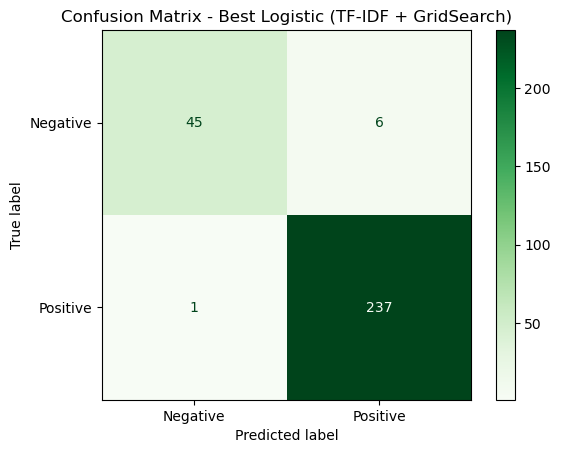

In [8]:
# =====================================================
# 7) TUNED LOGISTIC (TF-IDF + GRIDSEARCHCV)
# =====================================================

# Build pipeline: TF-IDF + Logistic Regression
pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=500))
])

# Grid of hyperparameters to try
param_grid = {
    # TF-IDF settings
    "tfidf__stop_words": ["english"],
    "tfidf__ngram_range": [(1, 1), (1, 2)],   # unigrams vs unigrams+bigrams
    "tfidf__max_features": [3000, 5000, 8000],

    # Logistic Regression settings
    "clf__C": [0.1, 1, 10],                   # regularization strength
    "clf__class_weight": ["balanced"],
    "clf__solver": ["liblinear"],             # good for small/medium data
}
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="f1_macro",   # balance performance between classes
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print("\n===== BEST PARAMS FROM GRIDSEARCH =====")
print(grid.best_params_)
print("Best CV Score (F1-macro):", grid.best_score_)

# Evaluate best model
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)
print("\n===== TEST PERFORMANCE (BEST LOGISTIC MODEL) =====")
best_acc = accuracy_score(y_test, y_pred_best)
print("Accuracy:", best_acc)

print("\nClassification Report (Best Logistic):")
print(classification_report(y_test, y_pred_best))

cm_best = confusion_matrix(y_test, y_pred_best)
print("\nConfusion Matrix (Best Logistic):")
print(cm_best)

plt.figure(figsize=(4, 4))
ConfusionMatrixDisplay(cm_best, display_labels=best_model.classes_).plot(
    cmap="Greens", values_format="d"
)
plt.title("Confusion Matrix - Best Logistic (TF-IDF + GridSearch)")
plt.show()

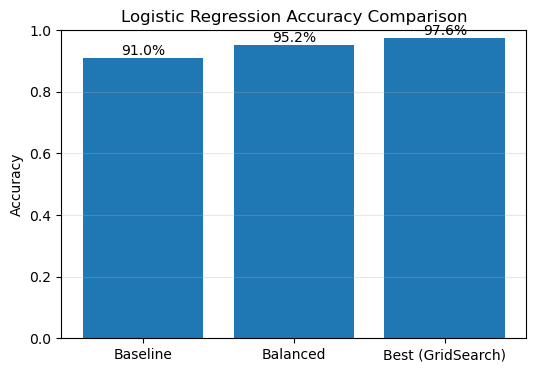

In [9]:
# =====================================================
# 8) COMPARE ACCURACY: BASELINE vs BALANCED vs BEST
# =====================================================

plt.figure(figsize=(6, 4))
model_names = ["Baseline", "Balanced", "Best (GridSearch)"]
accuracies = [base_acc, bal_acc, best_acc]

plt.bar(model_names, accuracies)
plt.ylim(0, 1.0)
plt.title("Logistic Regression Accuracy Comparison")
plt.ylabel("Accuracy")

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v*100:.1f}%", ha="center")

plt.grid(axis="y", alpha=0.3)
plt.show()

In [10]:
# =====================================================
# 9) MANUAL TESTS (10 CUSTOM REVIEWS)
# =====================================================

# 9.1 Mixed difficulty test (you already used this set)
test_sentences = [
    "The food was amazing and the service was excellent.",  # clear positive
    "Terrible experience. The waiter was rude and the food was cold.",  # clear negative
    "Great atmosphere and friendly staff.",                 # positive
    "The meal was bad and I will not come again.",          # negative
    "The food was good, but the service was slow.",         # mixed
    "I liked the dessert, but everything else was disappointing.",  # mixed
    "Not the best, but not the worst either.",              # neutral-ish
    "I would have enjoyed the meal if it wasn't so salty.", # negative
    "This place never fails to disappoint me.",             # tricky negative
    "The food was not bad at all, but I expected something better."  # tricky
]

test_df = pd.DataFrame({"review": test_sentences})

pred_labels = best_model.predict(test_df["review"])
if hasattr(best_model, "predict_proba"):
    pred_proba = best_model.predict_proba(test_df["review"])
else:
    pred_proba = None

print("\n===== TEST ON 10 CUSTOM REVIEWS (Best Logistic) =====\n")

for i, text in enumerate(test_sentences):
    print(f"Review {i+1}: {text}")
    print(f"Predicted Sentiment: {pred_labels[i]}")
    
    if pred_proba is not None:
        probs = pred_proba[i]
        neg_idx = list(best_model.classes_).index("Negative")
        pos_idx = list(best_model.classes_).index("Positive")
        print(f"Probabilities -> Negative: {probs[neg_idx]:.3f}, Positive: {probs[pos_idx]:.3f}")
    
    print("-" * 80)


===== TEST ON 10 CUSTOM REVIEWS (Best Logistic) =====

Review 1: The food was amazing and the service was excellent.
Predicted Sentiment: Positive
Probabilities -> Negative: 0.008, Positive: 0.992
--------------------------------------------------------------------------------
Review 2: Terrible experience. The waiter was rude and the food was cold.
Predicted Sentiment: Negative
Probabilities -> Negative: 0.964, Positive: 0.036
--------------------------------------------------------------------------------
Review 3: Great atmosphere and friendly staff.
Predicted Sentiment: Positive
Probabilities -> Negative: 0.008, Positive: 0.992
--------------------------------------------------------------------------------
Review 4: The meal was bad and I will not come again.
Predicted Sentiment: Negative
Probabilities -> Negative: 0.916, Positive: 0.084
--------------------------------------------------------------------------------
Review 5: The food was good, but the service was slow.
Predicte

In [11]:
# =====================================================
# 10) EASY TEST (10 SIMPLE CLEAR REVIEWS)
# =====================================================

easy_test_sentences = [
    "The food was delicious and the staff were very friendly.",
    "Amazing restaurant, I really enjoyed my meal.",
    "Great service and excellent atmosphere.",
    "The dessert was perfect and beautifully presented.",
    "I had a wonderful experience and will definitely come back.",
    "The food was terrible and tasted old.",
    "Very bad experience, the service was awful.",
    "I waited an hour and the meal arrived cold.",
    "The place was dirty and the staff were rude.",
    "I regret coming here, nothing was good."
]

easy_df = pd.DataFrame({"review": easy_test_sentences})
easy_preds = best_model.predict(easy_df["review"])
if hasattr(best_model, "predict_proba"):
    easy_proba = best_model.predict_proba(easy_df["review"])
else:
    easy_proba = None

print("\n===== EASY TEST RESULTS (10 Simple Reviews) =====\n")

for i, text in enumerate(easy_test_sentences):
    print(f"Review {i+1}: {text}")
    print(f"Predicted: {easy_preds[i]}")
    
    if easy_proba is not None:
        probs = easy_proba[i]
        neg_idx = list(best_model.classes_).index("Negative")
        pos_idx = list(best_model.classes_).index("Positive")
        print(f"Probabilities -> Negative: {probs[neg_idx]:.3f}, Positive: {probs[pos_idx]:.3f}")
    
    print("-" * 80)


===== EASY TEST RESULTS (10 Simple Reviews) =====

Review 1: The food was delicious and the staff were very friendly.
Predicted: Positive
Probabilities -> Negative: 0.009, Positive: 0.991
--------------------------------------------------------------------------------
Review 2: Amazing restaurant, I really enjoyed my meal.
Predicted: Positive
Probabilities -> Negative: 0.043, Positive: 0.957
--------------------------------------------------------------------------------
Review 3: Great service and excellent atmosphere.
Predicted: Positive
Probabilities -> Negative: 0.004, Positive: 0.996
--------------------------------------------------------------------------------
Review 4: The dessert was perfect and beautifully presented.
Predicted: Positive
Probabilities -> Negative: 0.074, Positive: 0.926
--------------------------------------------------------------------------------
Review 5: I had a wonderful experience and will definitely come back.
Predicted: Positive
Probabilities -> Neg